In [68]:
%%capture --no-stderr
!pip install --upgrade langchain langgraph langchain-google-genai google-generativeai

In [69]:
import getpass
import os
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")
_set_if_undefined("GOOGLE_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

System Prompt

In [71]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

Developing the Graph by creating various required functions

In [ ]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )

In [73]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

Final Graph

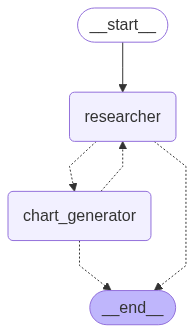

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Testing with prompt

{'researcher': {'messages': [HumanMessage(content='List balanced diet nutrient component and their amount and show them in a chart. Then finish.', additional_kwargs={}, response_metadata={}, id='87ba48d0-961d-4270-b747-9d5ac7d38563'), AIMessage(content="I can research the recommended daily intake of various nutrients for a balanced diet, but I can't create charts. I will provide the data to my chart generator colleague.", additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "recommended daily intake of nutrients balanced diet"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--e3f68bec-a53c-412a-a57b-38b68aefa02c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recommended daily intake of nutrients balanced diet'}, 'id': 'd5ad8745-e900-4b39-bebb-23a5074df445', 'type': 'tool_call'}], usage_met

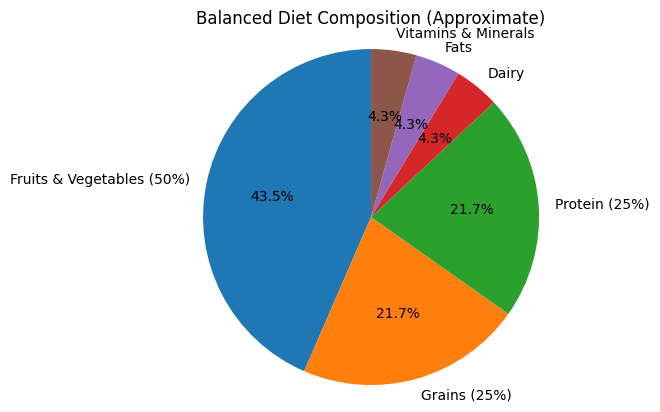

{'chart_generator': {'messages': [HumanMessage(content='List balanced diet nutrient component and their amount and show them in a chart. Then finish.', additional_kwargs={}, response_metadata={}, id='87ba48d0-961d-4270-b747-9d5ac7d38563'), AIMessage(content="I can research the recommended daily intake of various nutrients for a balanced diet, but I can't create charts. I will provide the data to my chart generator colleague.", additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "recommended daily intake of nutrients balanced diet"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--e3f68bec-a53c-412a-a57b-38b68aefa02c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recommended daily intake of nutrients balanced diet'}, 'id': 'd5ad8745-e900-4b39-bebb-23a5074df445', 'type': 'tool_call'}], usag

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "List balanced diet nutrient component and their amount and show them in a chart. Then finish.",
            )
        ],
    },
    {"recursion_limit": 50},
)
for s in events:
    print(s)
    print("----")